In [32]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

import cv2
import pickle

import dlib
import face_recognition as fr
import matplotlib.pyplot as plt
import re
import glob

import json
from urllib.request import urlopen
import time
import os

3 ~ 17번까지 한국 연예인

# 연예인 이름 목록

### 목록 크롤링

In [49]:
driver = webdriver.Chrome()
name_list_url = 'https://namu.wiki/w/%EC%97%B0%EC%98%88%EC%9D%B8/%EB%B3%B8%EB%AA%85%20%EB%B0%8F%20%EC%98%88%EB%AA%85'
driver.get(name_list_url)

def preprocess(name):
    name = re.sub('\(.+\)', '', name)
    name = name.strip()
    
    return name

name_list = []
error_list = []
for i in range(3,18):
    class_ = driver.find_elements_by_class_name('wiki-heading-content')[i]
    raw_name_list = class_.find_elements_by_css_selector('ul.wiki-list li')
    
    for raw_name in raw_name_list:
        split_name = raw_name.text.split('→')
        stage_name = preprocess(split_name[0])
        
        try:
            real_name = re.search('[가-힣]+', split_name[1])[0].strip()
        except Exception as e:
            error_list.append(raw_name.text)
            continue
            
        new_name = stage_name + ' ' + real_name
        name_list.append(new_name)
        
print(f'{len(name_list)} persons returned')
print(f'{len(error_list)} persons got error')

print(error_list)

1602 persons returned
3 persons got error
['동호(前 유키스) - 신동호☆', '마크(NCT) → Mark Lee☆', '유정(라붐) → → 김유정☆']


### 전처리
오타로 인해 다른 이름과 다르게 표시가 된 이름들 수정

In [3]:
stage_name = preprocess(error_list[0].split('-')[0])
real_name = re.search('[가-힣]+', error_list[0].split('-')[1])[0]
print(stage_name, real_name)
name_list.append(stage_name + ' ' + real_name)

stage_name = preprocess(error_list[1].split('→')[0])
real_name = re.search('[가-힣A-Za-z ]+', error_list[1].split('→')[1])[0].strip()
print(stage_name, real_name)
name_list.append(stage_name + ' ' + real_name)

stage_name = preprocess(error_list[2].split('→')[0])
real_name = re.search('[가-힣A-Za-z ]+', error_list[2].split('→')[-1])[0].strip()
print(stage_name, real_name)
name_list.append(stage_name + ' ' + real_name)

동호 신동호
마크 Mark Lee
유정 김유정


### 목록 이름 저장

In [13]:
name_list = name_list[6:]
with open('celebrity/celebrity_name.pkl', 'wb') as f:
    pickle.dump(name_list, f)

with open('celebrity/celebrity_name.pkl', 'rb') as f:
    celebrity_name_list = pickle.load(f)
len(celebrity_name_list)

# 얼굴 크롤링 간 조건
다양한 얼굴 중 임베딩에 가장 적합한 이미지를 크롤링하기위해 조건 설정
- 썬글라스 착용 시 제외
- 마스크 착용 시 제외
- 얼굴 각도가 좌,우로 돌아간 경우 제외
- 이미지 크기가 340x340보다 작으면 제외
  - 제외되는 경우가 너무 많아서 크기 수정

### 썬글라스 탐지
눈 주위의 픽셀값을 이용해 썬글라스 착용 여부 탐지
- 왼쪽 : Landmark 36 ~ 41
- 오른쪽 : Landmakr 42 ~ 47
- luminance를 이용해 밝기 측정

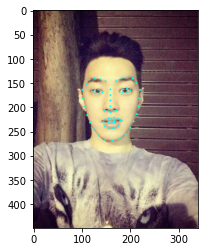

In [39]:
example = fr.load_image_file('celebrity/GRAY 이성화.jpg')
example_show = example.copy()

landmarks = fr.face_landmarks(example)
landmarks = []
for k, v in fr.face_landmarks(example)[0].items():
    landmarks.extend(v)
for number, landmark in enumerate(landmarks):
    cv2.circle(example_show, landmark, 2, (0, 255, 255), -1)          
plt.imshow(example_show)

In [35]:
def get_brightness_around_eye(image):
    try:
        landmarks = []
        for k, v in fr.face_landmarks(image)[0].items():
            landmarks.extend(v)

        left1, right1 = landmarks[36][0], landmarks[39][0]
        top1, bottom1 = landmarks[37][1], landmarks[41][1]

        left2, right2 = landmarks[42][0], landmarks[45][0]
        top2, bottom2 = landmarks[43][1], landmarks[47][1]
        
        image[top1:bottom1, left1:right1] = np.nan
        image[top2:bottom2, left2:right2] = np.nan
        
        left_glass = image[top1-10:bottom1+10, left1-5:right1+5]
        right_glass = image[top2-10:bottom2+10, left2-5:right2+5]

        luminance_left = np.nanmean(0.2126*left_glass[:,:,0] + 0.7152*left_glass[:,:,1] + 0.0722*left_glass[:,:,2])
        luminance_right = np.nanmean(0.2126*right_glass[:,:,0] + 0.7152*right_glass[:,:,1] + 0.0722*right_glass[:,:,2])
        
        #luminance_left2 = np.nanmean(left_glass[:,:,0] + left_glass[:,:,1] + left_glass[:,:,2])
        #luminance_right2 = np.nanmean(right_glass[:,:,0] + right_glass[:,:,1] + right_glass[:,:,2])
        
        return luminance_left, luminance_right
    
    except:
        return None

### 마스크 착용 탐지
다양한 얼굴 중 마스크 착용 시 제외
- 입 주변의 픽셀값을 이용해 마스크 착용 여부 탐지
- Lanmark 2, 6, 11, 14 사용

In [ ]:
# 랜드마크 2, 6, 11, 14
def get_brightness_around_mouse(image):
    landmarks = []
    for k, v in fr.face_landmarks(image)[0].items():
        landmarks.extend(v)

    left1, right1 = landmarks[6][0], landmarks[11][0]
    top1, bottom1 = landmarks[2][1], landmarks[6][1]

    mask = image[top1:bottom1, left1:right1]

    mask_luminance = np.nanmean(0.2126*mask[:,:,0] + 0.7152*mask[:,:,1] + 0.0722*mask[:,:,2])
    return mask_luminance

### 얼굴 각도 측정
얼굴이 좌,우로 돌아간 정도를 측정해 정면이 아닐 시 제외
- 왼쪽과 오른쪽 볼의 길이차를 이용해 회전 정도 측정
- Landmark 2, 14, 30 사용

In [1]:
def ratio_of_face_rotate(image):
    landmarks = []
    for k, v in fr.face_landmarks(image)[0].items():
        landmarks.extend(v)

    left = np.linalg.norm(np.array(landmarks[30]) - np.array(landmarks[2]))
    right = np.linalg.norm(np.array(landmarks[30]) - np.array(landmarks[14]))
    ratio = min(left, right) / max(left, right)
    
    return ratio

### 이미지 사이즈 조건
행 : 404.16
열 : 340.0

# 이미지 크롤링
크롤링 간 사용하는 유용함 함수는 따로 정의

### 이미지 저장
사이트로부터 얻은 이미지의 URL을 이용해 이미지 다운로드

In [ ]:
def save_image_from_url(image_url):
    with urlopen(image_url.get_attribute('src')) as f:
        with open(f'celebrity/{name}.jpg', 'wb') as file_name:
            img = f.read()
            file_name.write(img)
            
    return img, file_name

### 이미지 다운로드

In [ ]:
delay=2
error_name = []
driver = webdriver.Chrome()
for name in name_list:
    driver.get(f'https://search.naver.com/search.naver?where=image&sm=tab_jum&query={name}')
    time.sleep(0.2)
    try:
        myElem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((By.TAG_NAME, 'section')))
        driver.find_element_by_tag_name('html').send_keys(Keys.END)
        
        image_url_list = driver.find_elements_by_css_selector('div.tile_item._item img._image._listImage')[:50]
        
        is_succeed = 0
        for image_url in image_url_list:
            
            img, file_name = save_image_from_url(image_url)
            
            error_message = ''
            try:
                image = fr.load_image_file(file_name.name)
                if (image.shape[0] < 200) or (image.shape[1] < 200):
                    print(name, 'Too Small')
                    continue
                
                locations = fr.face_locations(image)
                if len(locations) != 1:
                    print(name, 'No Face')
                    continue
                    
                top, right, bottom, left = locations[0]
                face_cropped = image[top:bottom, left:right]
                if (face_cropped.shape[0] < 30) or (face_cropped.shape[1] < 30):
                    print(name, 'Cropped Too Small')
                    continue
                
                face_embedding = fr.face_encodings(face_cropped)
                if len(face_embedding) != 1:
                    print(name, 'No Embedding')
                    continue
                                  
                ratio = ratio_of_face_rotate(image)
                if ratio < 0.85:
                    print(name, 'Rotated')
                    continue
                    
                left_eye, right_eye = get_brightness_around_eye(image)
                if (left_eye < 60) & (right_eye < 60):
                    print(name, 'Maybe Sunglasses')
                    continue
                
                mask = get_brightness_around_mouse(image)
                if mask > 220:
                    print(name, 'Maybe Mask?')
                                
                is_succeed = 1
                print(name, 'Succeed')
                break
                                      
            except Exception as ex:
                print(name, 'failed detection', ex)
                continue
                
        if is_succeed == 0:
            os.remove(file_name.name)
            error_name.append(name)
            print(name, 'collecting Failed')
        
    except Exception as ex:
        print(name, ex)
        error_name.append(name)